In [1]:
import pytube
import moviepy.editor as mp
from gtts import gTTS
from dtw import dtw
import io
import matplotlib.pyplot as plt
import numpy as np
import librosa
import IPython.display
from IPython.display import Image
import copy
import os
import json
import soundfile as sf
import base64
%matplotlib inline

In [2]:
def preprocess_mfcc(mfcc):
    mfcc_cp = copy.deepcopy(mfcc)
    for i in range(mfcc.shape[1]):
        mfcc_cp[:,i] = mfcc[:,i] - np.mean(mfcc[:,i])
        mfcc_cp[:,i] = mfcc_cp[:,i]/np.max(np.abs(mfcc_cp[:,i]))
    return mfcc_cp

In [3]:
def getTimeRange(dists:list, window_size:int):
    # smallest value index
    word_match_idx = dists.argmin()
    # get index bounds
    word_match_idx_bnds = np.array([word_match_idx, np.ceil(word_match_idx+window_size)])
    samples_per_mfcc = 512
    # get time bounds
    word_samp_bounds = word_match_idx_bnds*samples_per_mfcc
    return (int(word_samp_bounds[0]),int(word_samp_bounds[1]))

## Download audio

In [6]:
url = r'https://youtu.be/OnAA1dIG6iY'

In [7]:
youtube = pytube.YouTube(url)
video = youtube.streams.get_highest_resolution()
video.download()
video_title = video.default_filename
print(video_title)

J&T  Sistem Pengagihan Bonus Tak Jelas.mp4


In [8]:
clip = mp.VideoFileClip(video_title) 
audio_file_name = video_title[:-4]+ ".wav"
clip.audio.write_audiofile(audio_file_name)

chunk:   0%|                                                                        | 0/2109 [00:00<?, ?it/s, now=None]

MoviePy - Writing audio in J&T  Sistem Pengagihan Bonus Tak Jelas.wav


MoviePy - Done.


## Constants

In [41]:
FULL_SENTENCE = 'kurang jelas terhadap sistem pengagihan bonus dalam kalangan pegawai jabatan menjadi punca kepada kejadian mogok dan tindakan melempar barangan milik pelanggan oleh kakitangan J&T Express'
SAMPLE_WORDS = FULL_SENTENCE.split()
FULL_FOLDER = 'full'
SAMPLE_FOLDER_1 = 'sample 1'
SAMPLE_FOLDER_2 = 'sample 2'
GRAPH_FOLDER_1 = 'graph 1'
GRAPH_FOLDER_2 = 'graph 2'
DETECTED_FOLDER_1 = 'detected 1'
DETECTED_FOLDER_2 = 'detected 2'
print(SAMPLE_WORDS)

['kurang', 'jelas', 'terhadap', 'sistem', 'pengagihan', 'bonus', 'dalam', 'kalangan', 'pegawai', 'jabatan', 'menjadi', 'punca', 'kepada', 'kejadian', 'mogok', 'dan', 'tindakan', 'melempar', 'barangan', 'milik', 'pelanggan', 'oleh', 'kakitangan', 'J&T', 'Express']


## Read audio sample 1

In [5]:
AUDIO_SAMPLE_1 = []
for i, word in enumerate(SAMPLE_WORDS):
    full_name = f'{i+1}_{word}.mp3'
    audio, rate = librosa.load(os.path.join(SAMPLE_FOLDER_1, full_name))
    AUDIO_SAMPLE_1.append((audio, rate))
    
print(len(AUDIO_SAMPLE_1))

25


## Read audio sample 2

In [7]:
AUDIO_SAMPLE_2 = []
for i, word in enumerate(SAMPLE_WORDS):
    full_name = f'{i+1}_{word}.mp3'
    audio, rate = librosa.load(os.path.join(SAMPLE_FOLDER_2, full_name))
    AUDIO_SAMPLE_2.append((audio, rate))
    
print(len(AUDIO_SAMPLE_2))

25


In [8]:
# print(audio_samples)

## Read target audio

In [9]:
TARGET_FULL_AUDIO, TARGET_FULL_RATE = librosa.load(os.path.join(target_folder, target_audio_name))
print(TARGET_FULL_RATE)

22050


## Preprocess Sample 1

In [10]:
# get mfcc for each audio samples
mfcc_samples_1 = []
for i, (sample_audio, sample_rate) in enumerate(AUDIO_SAMPLE_1):
    x_mfcc = librosa.feature.mfcc(sample_audio, sample_rate)
    x_mfcc = preprocess_mfcc(x_mfcc)
    mfcc_samples_1.append((x_mfcc,sample_rate))
    
print(len(mfcc_samples_1))

25


## Preprocess Sample 2

In [11]:
# get mfcc for each audio samples
mfcc_samples_2 = []
for i, (sample_audio, sample_rate) in enumerate(AUDIO_SAMPLE_2):
    x_mfcc = librosa.feature.mfcc(sample_audio, sample_rate)
    x_mfcc = preprocess_mfcc(x_mfcc)
    mfcc_samples_2.append((x_mfcc,sample_rate))
    
print(len(mfcc_samples_2))

25


## Preprocess Target

In [12]:
# get mfcc for target audio
target_full_mfcc = preprocess_mfcc(librosa.feature.mfcc(TARGET_FULL_AUDIO, TARGET_FULL_RATE))
print(target_full_mfcc.shape)

(20, 553)


## Checking

In [13]:
# check target audio
print(f'{target_audio_name}：{target_full_mfcc.shape}')

J&T Sistem Pengagihan Bonus Tak Jelas.mp3：(20, 553)


In [14]:
# check audio samples 1
for i, (sample_mfcc, sample_rate) in enumerate(mfcc_samples_1):
    print(f'{SAMPLE_WORDS[i]}：{sample_mfcc.shape}')

kurang：(20, 18)
jelas：(20, 16)
terhadap：(20, 17)
sistem：(20, 26)
pengagihan：(20, 27)
bonus：(20, 21)
dalam：(20, 15)
kalangan：(20, 24)
pegawai：(20, 30)
jabatan：(20, 24)
menjadi：(20, 21)
punca：(20, 24)
kepada：(20, 19)
kejadian：(20, 20)
mogok：(20, 21)
dan：(20, 12)
tindakan：(20, 21)
melempar：(20, 34)
barangan：(20, 17)
milik：(20, 13)
pelanggan：(20, 22)
oleh：(20, 9)
kakitangan：(20, 25)
J&T：(20, 29)
Express：(20, 24)


In [15]:
# check audio samples 2
for i, (sample_mfcc, sample_rate) in enumerate(mfcc_samples_2):
    print(f'{SAMPLE_WORDS[i]}：{sample_mfcc.shape}')

kurang：(20, 17)
jelas：(20, 17)
terhadap：(20, 16)
sistem：(20, 21)
pengagihan：(20, 29)
bonus：(20, 20)
dalam：(20, 23)
kalangan：(20, 31)
pegawai：(20, 20)
jabatan：(20, 26)
menjadi：(20, 22)
punca：(20, 21)
kepada：(20, 17)
kejadian：(20, 21)
mogok：(20, 20)
dan：(20, 12)
tindakan：(20, 23)
melempar：(20, 29)
barangan：(20, 21)
milik：(20, 15)
pelanggan：(20, 21)
oleh：(20, 12)
kakitangan：(20, 31)
J&T：(20, 37)
Express：(20, 35)


## DTW 1

In [16]:
# get window sizes for each audio samples
window_sizes_1 = np.array([int(mfcc_samples_1[i][0].shape[1]//1) for i in range(len(mfcc_samples_1))])
print(window_sizes_1)

[18 16 17 26 27 21 15 24 30 24 21 24 19 20 21 12 21 34 17 13 22  9 25 29
 24]


In [17]:
# prepare 2d list for dtw
dists_2d_1 = []
for i in range(len(mfcc_samples_1)):
    dists_2d_1.append(np.zeros(target_full_mfcc.shape[1] - window_sizes_1[i]))

print(len(dists_2d_1))

25


In [18]:
# dtw
# for each words
for i in range(len(SAMPLE_WORDS)): 
    # for each interval
    for j in range(len(dists_2d_1[i])): 
        part_target_mfcc = target_full_mfcc[:,j:j+window_sizes_1[i]]
        single_dist = dtw(part_target_mfcc.T, mfcc_samples_1[i][0].T, dist=lambda x, y: np.linalg.norm(x - y))[0]
        dists_2d_1[i][j] = single_dist

In [20]:
plt.rcParams["figure.figsize"] = (10,40)

In [21]:
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

25


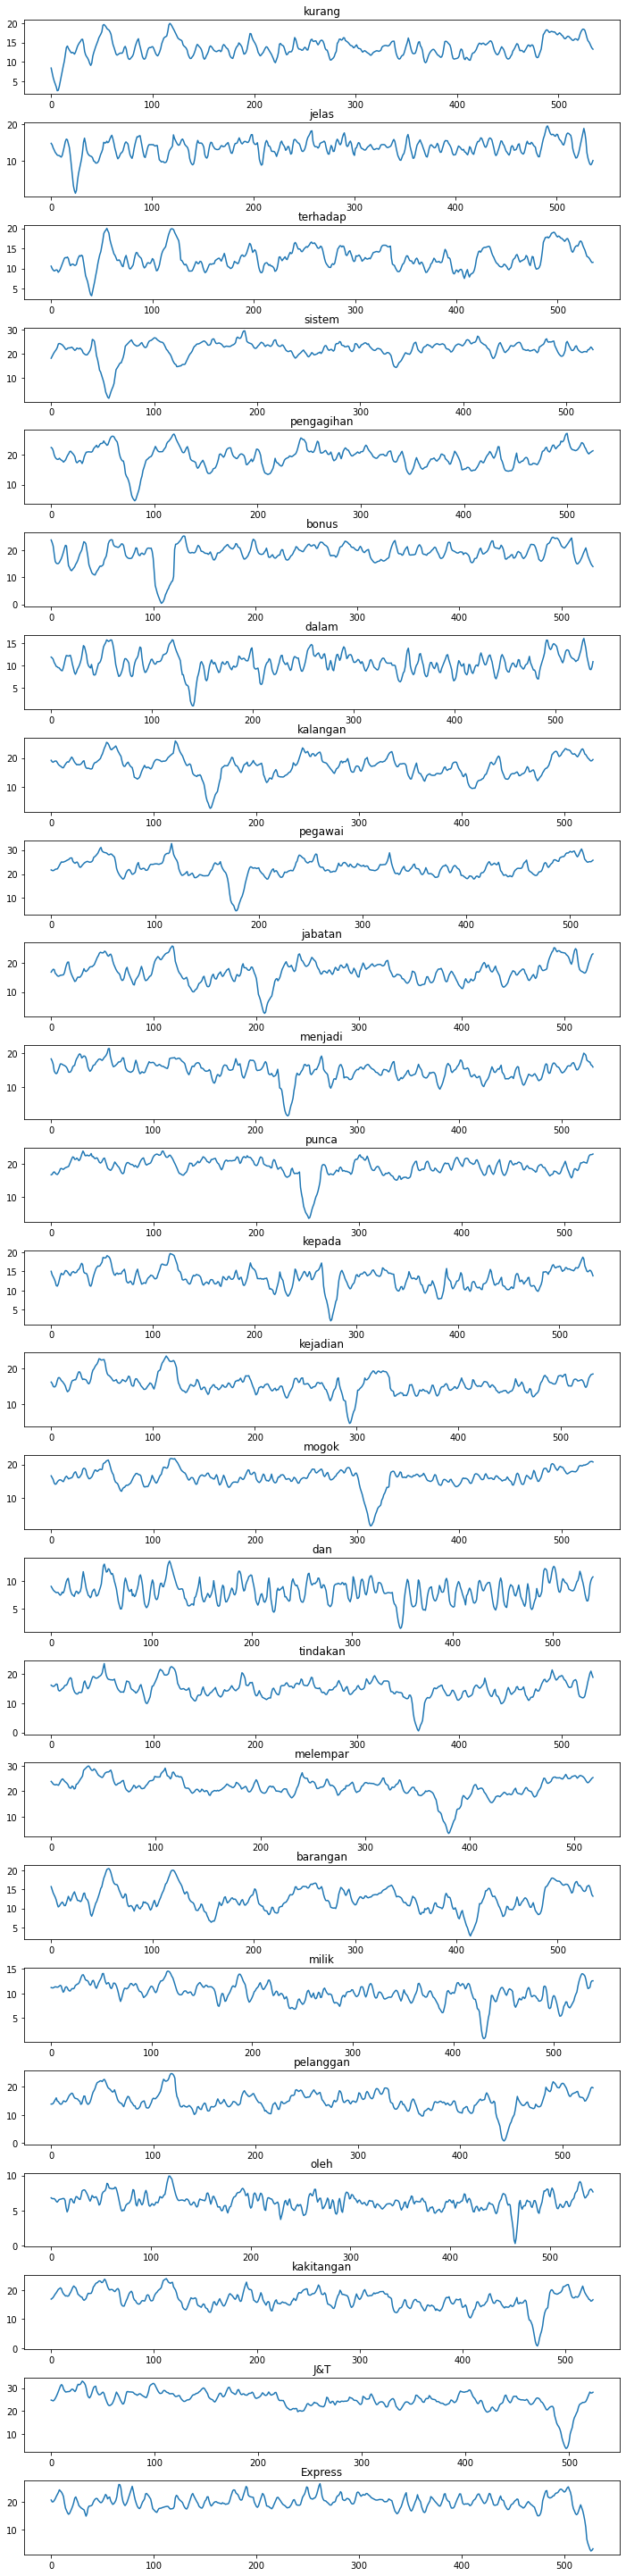

In [22]:
fig, axs = plt.subplots(len(dists_2d_1))
fig.tight_layout()
print(len(axs))
for i in range(len(axs)):
    axs[i].set_title(SAMPLE_WORDS[i])
    axs[i].plot(dists_2d_1[i])

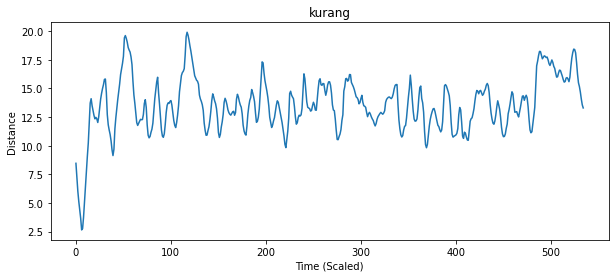

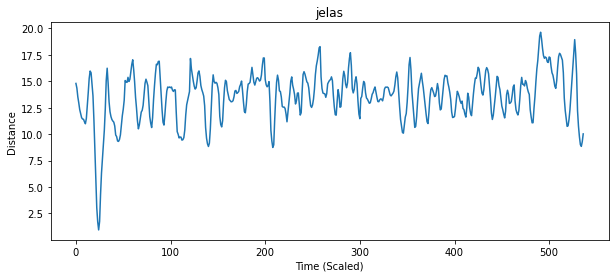

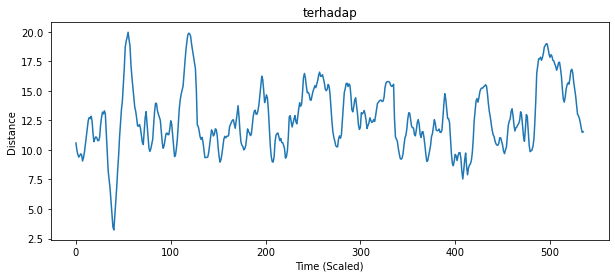

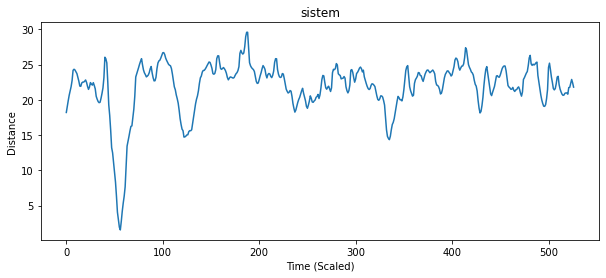

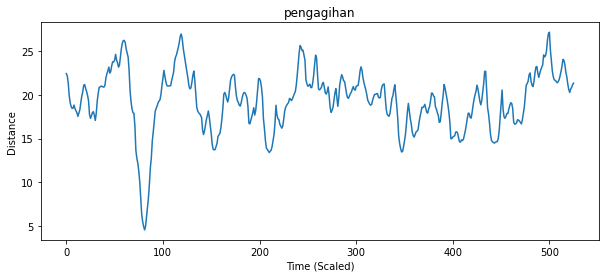

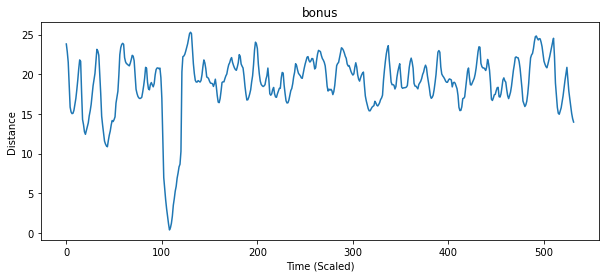

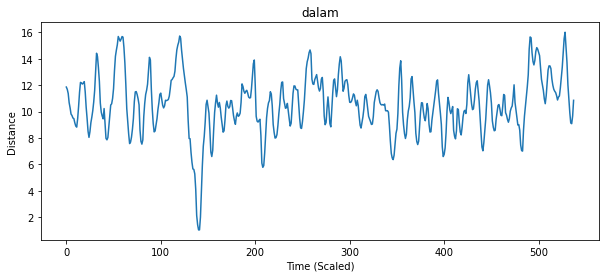

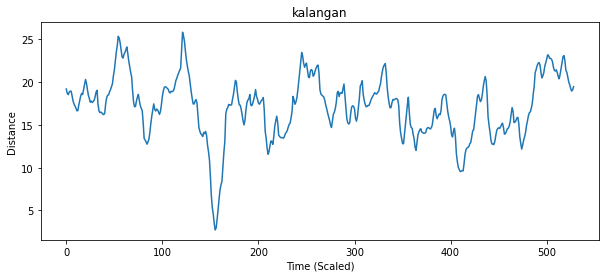

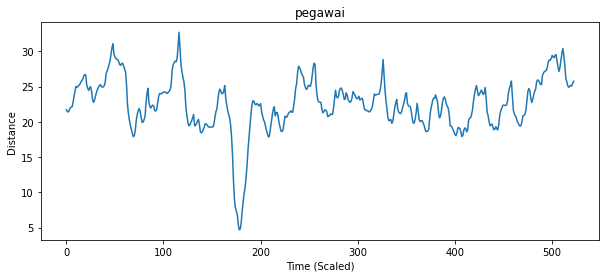

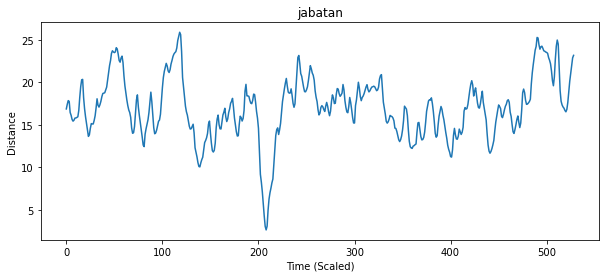

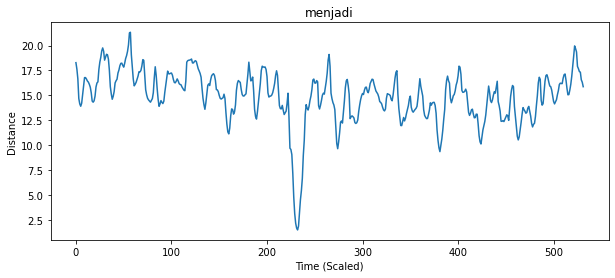

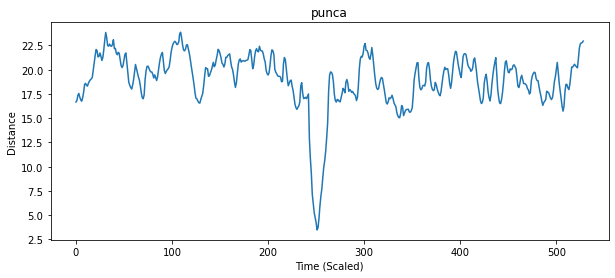

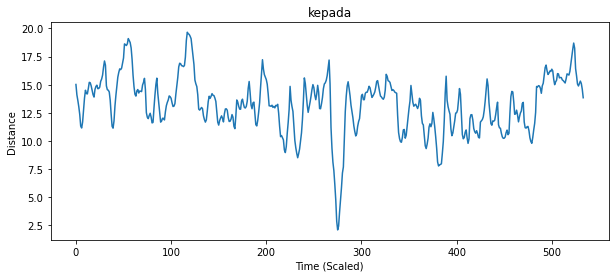

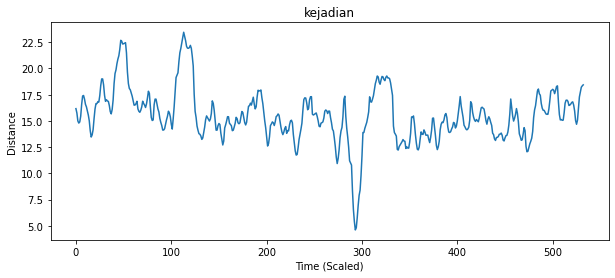

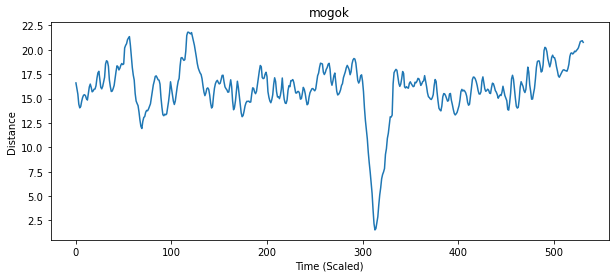

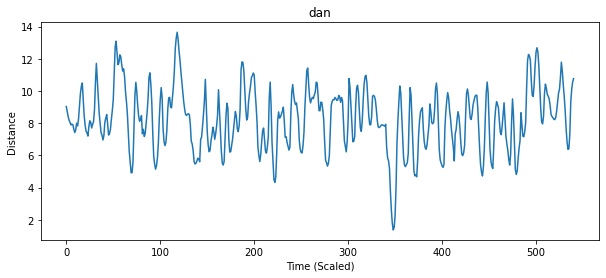

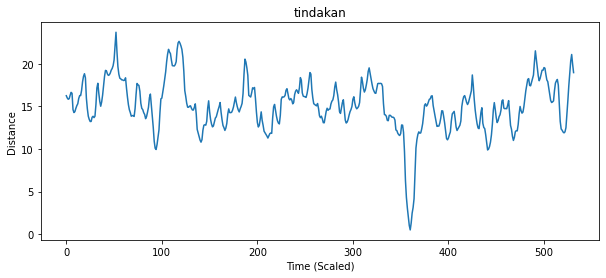

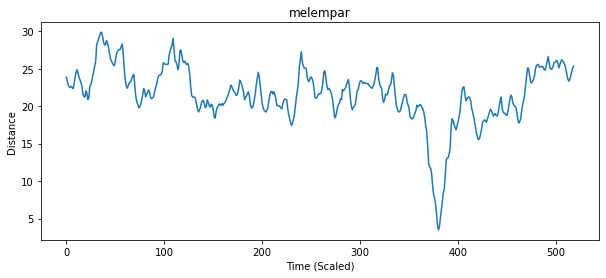

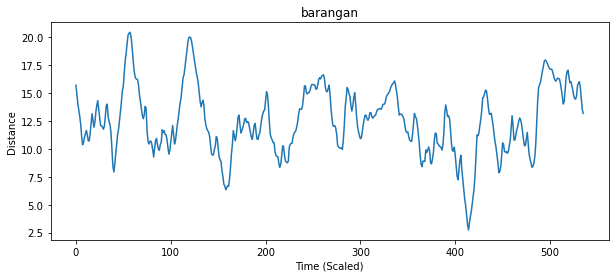

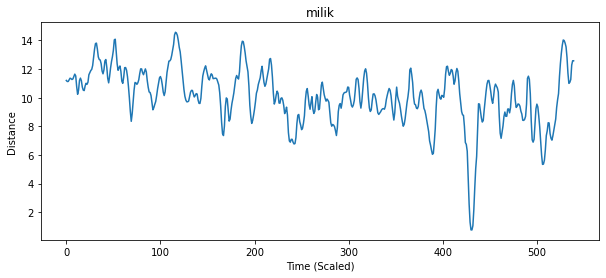

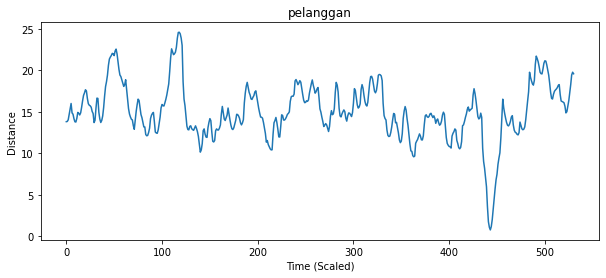

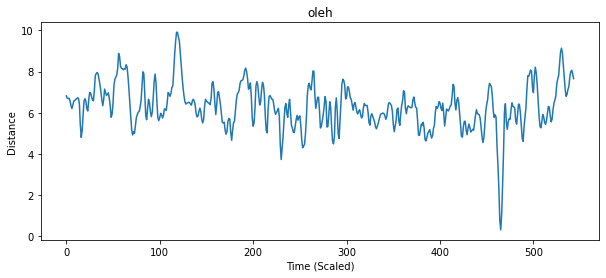

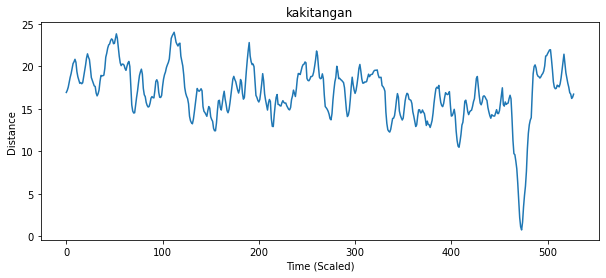

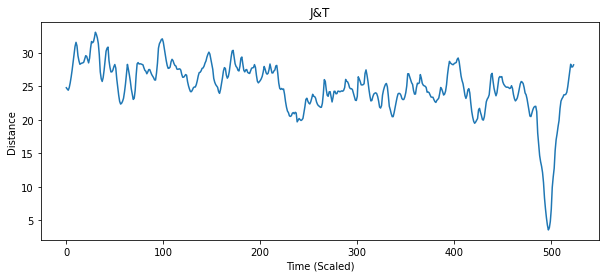

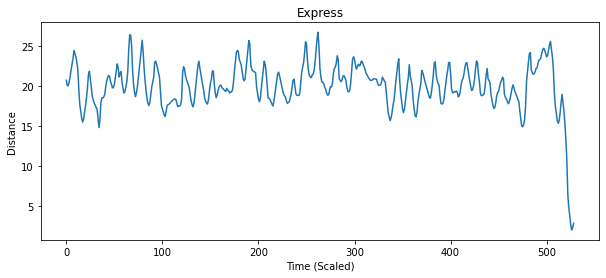

In [24]:
# save to jpg
plt.rcParams['figure.figsize'] = (10, 4)

for i in range(len(dists_2d_1)):
    fig, ax = plt.subplots()
    ax.set_title(SAMPLE_WORDS[i])
    ax.set_xlabel('Time (Scaled)')
    ax.set_ylabel('Distance')
    ax.plot(dists_2d_1[i])
    fig.savefig(fname=os.path.join(GRAPH_FOLDER_1, f'{i+1}_{SAMPLE_WORDS[i]}.jpg'), dpi=200, bbox_inches='tight', pad_inches=0.1)

In [23]:
timeRanges_1 = []
for i in range(len(SAMPLE_WORDS)):
    time = getTimeRange(dists_2d_1[i], window_sizes_1[i])
#     print(time)
    timeRanges_1.append(time)
    
print(len(timeRanges_1))

25


## DTW 2

In [24]:
# get window sizes for each audio samples
window_sizes_2 = np.array([int(mfcc_samples_2[i][0].shape[1]//1) for i in range(len(mfcc_samples_2))])
print(window_sizes_2)

[17 17 16 21 29 20 23 31 20 26 22 21 17 21 20 12 23 29 21 15 21 12 31 37
 35]


In [25]:
# prepare 2d list for dtw
dists_2d_2 = []
for i in range(len(mfcc_samples_2)):
    dists_2d_2.append(np.zeros(target_full_mfcc.shape[1] - window_sizes_2[i]))

print(len(dists_2d_2))

25


In [26]:
# dtw
# for each words
for i in range(len(SAMPLE_WORDS)): 
    # for each interval
    for j in range(len(dists_2d_2[i])): 
        part_target_mfcc = target_full_mfcc[:,j:j+window_sizes_2[i]]
        single_dist = dtw(part_target_mfcc.T, mfcc_samples_2[i][0].T, dist=lambda x, y: np.linalg.norm(x - y))[0]
        dists_2d_2[i][j] = single_dist

In [28]:
plt.rcParams["figure.figsize"] = (10,40)

In [29]:
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

25


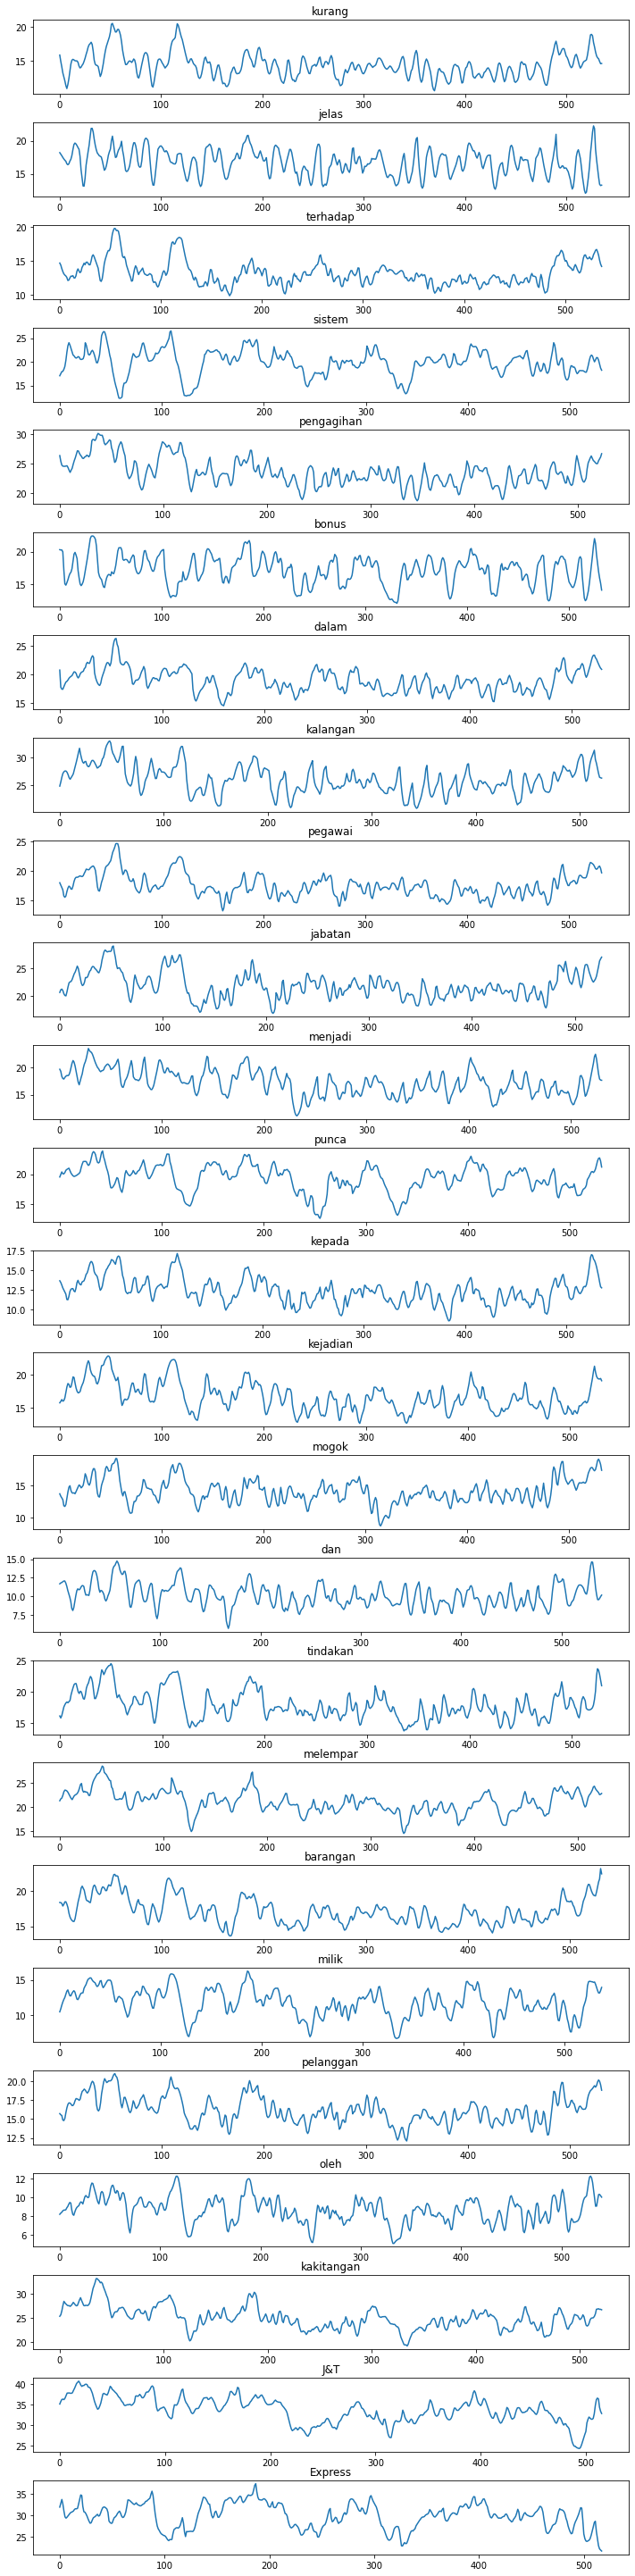

In [30]:
fig, axs = plt.subplots(len(dists_2d_2))
fig.tight_layout()
print(len(axs))
for i in range(len(axs)):
    axs[i].set_title(SAMPLE_WORDS[i])
    axs[i].plot(dists_2d_2[i])

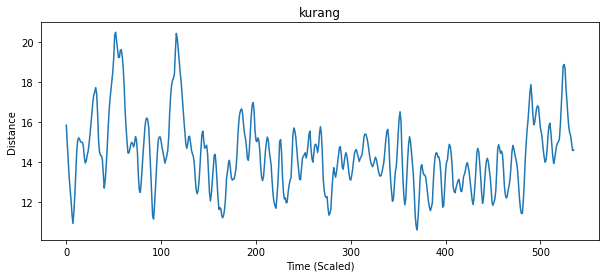

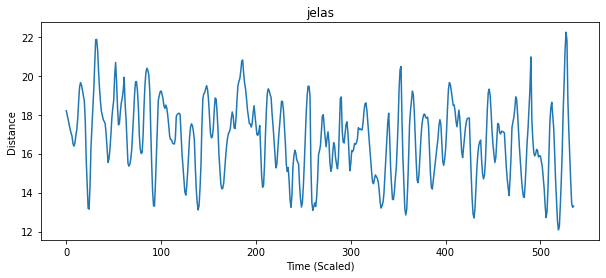

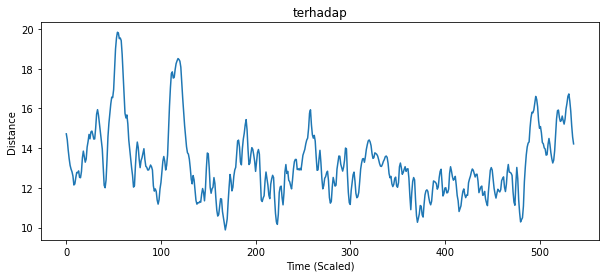

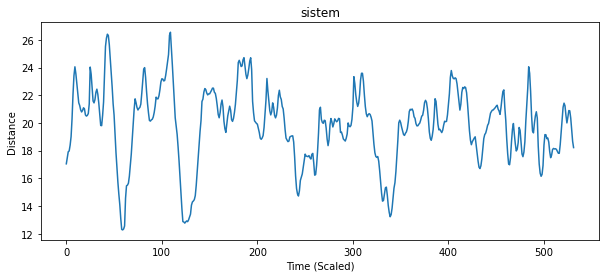

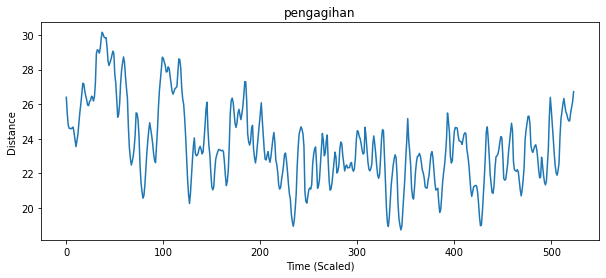

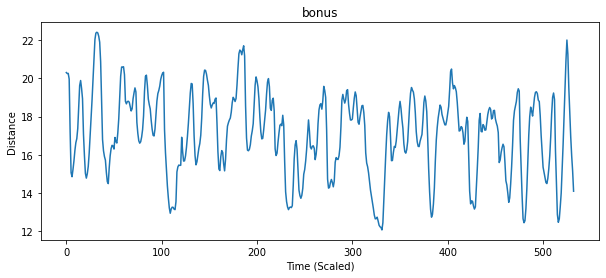

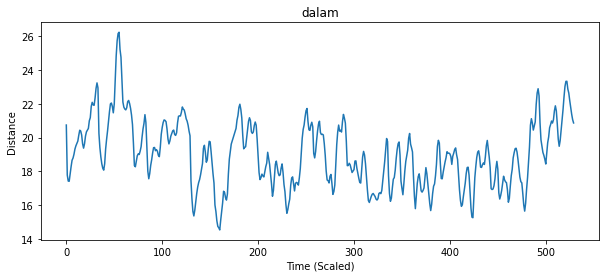

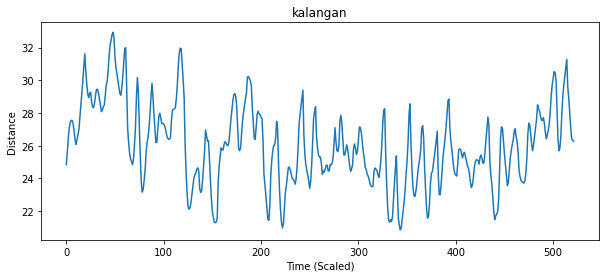

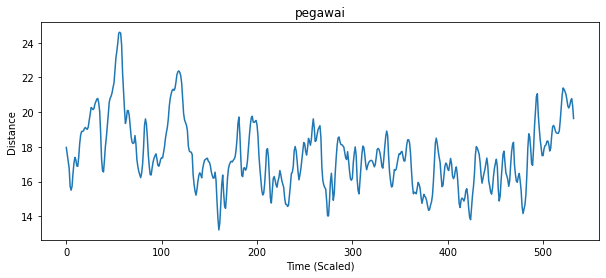

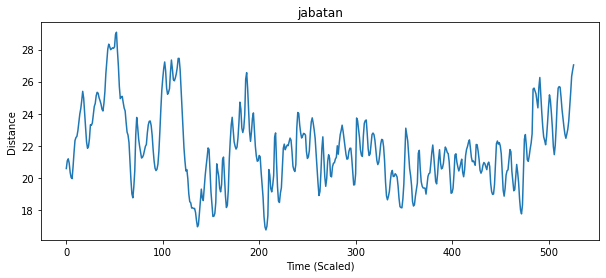

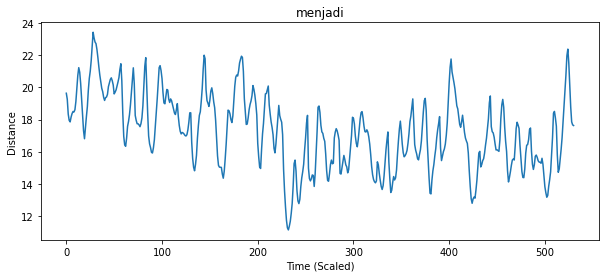

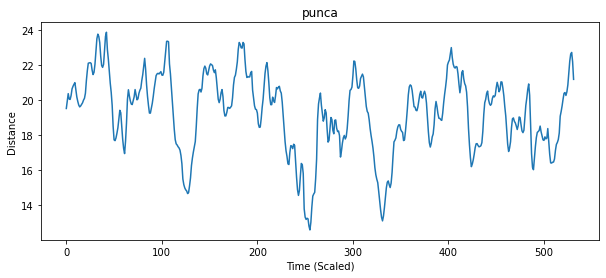

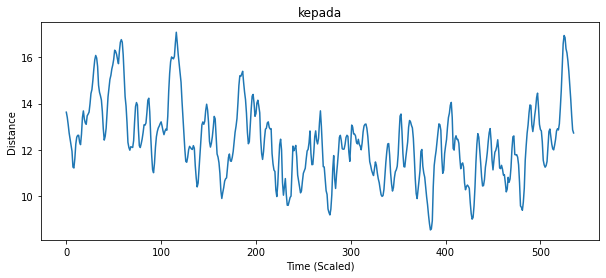

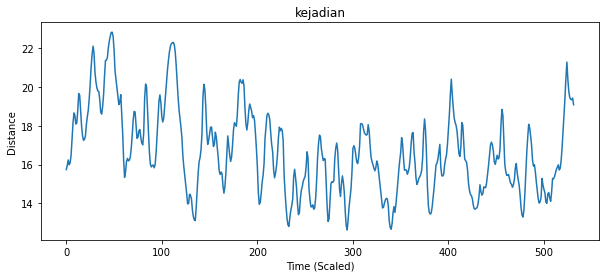

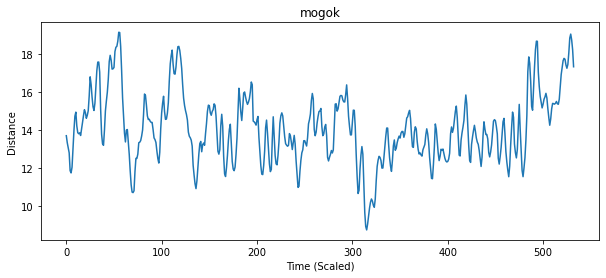

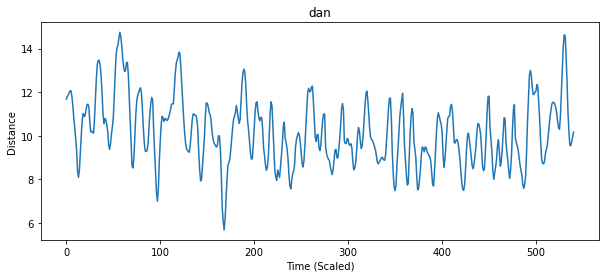

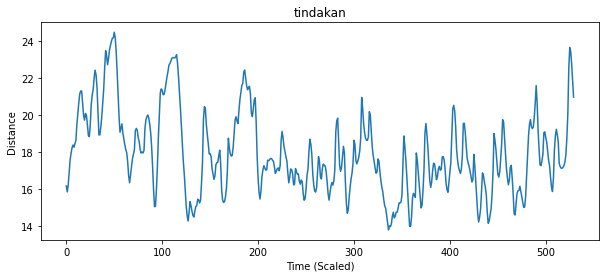

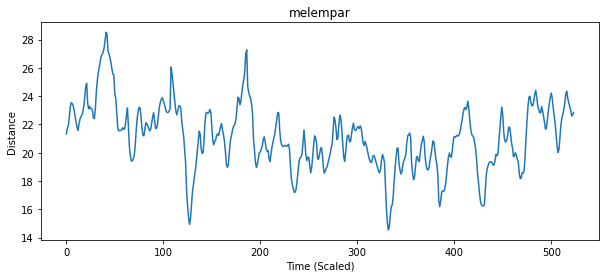

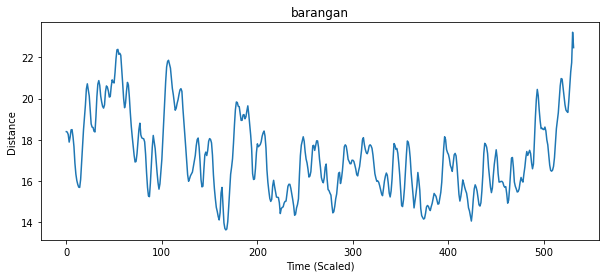

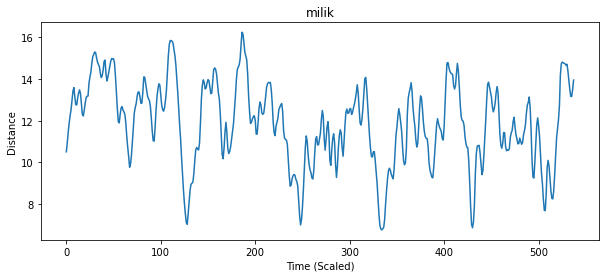

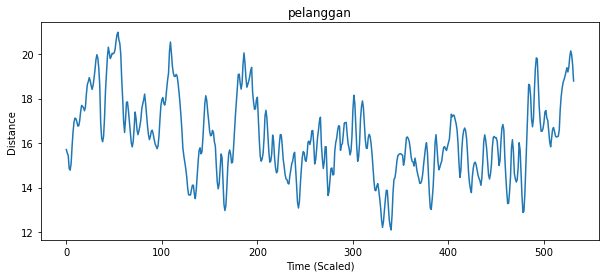

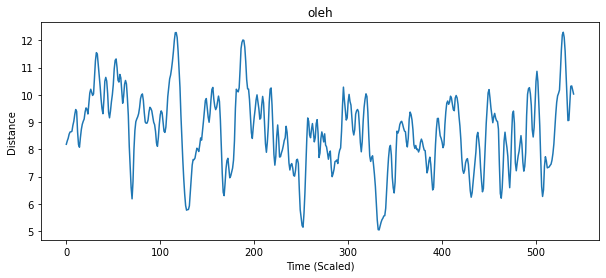

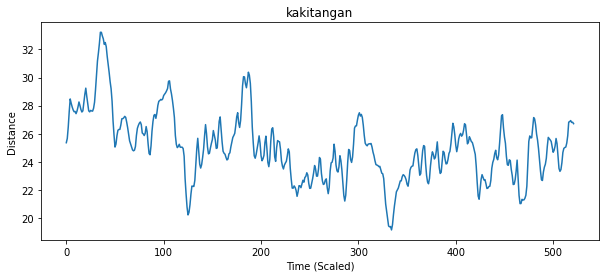

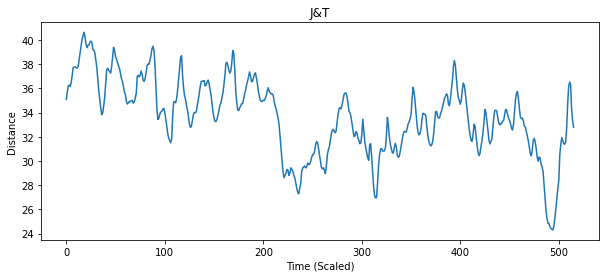

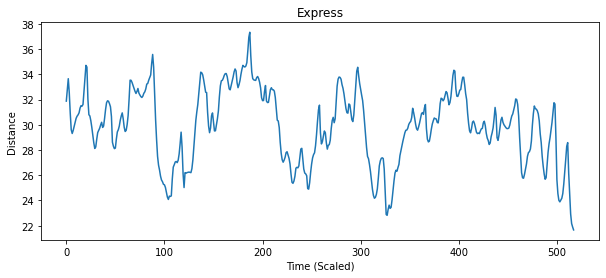

In [40]:
# save to jpg
plt.rcParams['figure.figsize'] = (10, 4)

for i in range(len(dists_2d_2)):
    fig, ax = plt.subplots()
    ax.set_title(SAMPLE_WORDS[i])
    ax.set_xlabel('Time (Scaled)')
    ax.set_ylabel('Distance')
    ax.plot(dists_2d_2[i])
    fig.savefig(fname=os.path.join(GRAPH_FOLDER_2, f'{i+1}_{SAMPLE_WORDS[i]}.jpg'), dpi=200, bbox_inches='tight', pad_inches=0.1)

In [31]:
timeRanges_2 = []
for i in range(len(SAMPLE_WORDS)):
    time = getTimeRange(dists_2d_2[i], window_sizes_2[i])
#     print(time)
    timeRanges_2.append(time)
    
print(len(timeRanges_2))

25


## Postprocess

In [39]:
def save_mp3(audio, rate, outFile):
    # Write out audio as 24bit PCM WAV
    sf.write(outFile, audio, rate, subtype='PCM_24')

In [43]:
# save to file
for i, word in enumerate(SAMPLE_WORDS):
    # sample 1
    detected_path_1 = os.path.join(DETECTED_FOLDER_1, f'{i+1}_{word}.wav')
    data_1 = TARGET_FULL_AUDIO[timeRanges_1[i][0]:timeRanges_1[i][1]]
    rate_1 = AUDIO_SAMPLE_1[i][1]
    save_mp3(data_1, rate_1, detected_path_1)
    # sample 2
    detected_path_2 = os.path.join(DETECTED_FOLDER_2, f'{i+1}_{word}.wav')
    data_2 = TARGET_FULL_AUDIO[timeRanges_2[i][0]:timeRanges_2[i][1]]
    rate_2 = AUDIO_SAMPLE_2[i][1]
    save_mp3(data_2, rate_2, detected_path_2)

In [32]:
def convert_librosa_2_base64(audio, rate) -> str:
    filepath = "temp.wav"
    # Write out audio as 24bit PCM WAV
    sf.write(filepath, audio, rate, subtype='PCM_24')
    # read file into RAM and encode it
    res = ''
    with open(filepath, 'rb') as f:
        audio_encoded = base64.b64encode(f.read())
        res = str(audio_encoded.decode())
    return res

In [46]:
# save to json
raw_data = {}

# target
full_target_audio_data = {
    "audio_title":target_audio_name,
    "source_link":url,
    "target_audio_path":os.path.join(PARENT, target_folder, target_audio_name),
    "transcript":FULL_SENTENCE
}

raw_data["full_target_audio"] = full_target_audio_data

# sample 1
sample_audio_1_data = []
for i, word in enumerate(SAMPLE_WORDS):
    img_path = os.path.join(PARENT, GRAPH_FOLDER_1, f'{i+1}_{word}.jpg')
    actual_audio_path = os.path.join(PARENT, SAMPLE_FOLDER_1, f'{i+1}_{word}.mp3')
    detected_audio_path = os.path.join(PARENT, DETECTED_FOLDER_1, f'{i+1}_{word}.wav')
    data = TARGET_FULL_AUDIO[timeRanges_1[i][0]:timeRanges_1[i][1]]
    rate = AUDIO_SAMPLE_1[i][1]
    
    data = {
        "actual_word":word,
        "graph_img_path":img_path,
        "actual_audio_path":actual_audio_path,
        "detected_audio_path":detected_audio_path
    }
    sample_audio_1_data.append(data)

raw_data["sample_audio_1"] = sample_audio_1_data

# sample 2
sample_audio_2_data = []
for i, word in enumerate(SAMPLE_WORDS):
    img_path = os.path.join(PARENT, GRAPH_FOLDER_2, f'{i+1}_{word}.jpg')
    actual_audio_path = os.path.join(PARENT, SAMPLE_FOLDER_2, f'{i+1}_{word}.mp3')
    detected_audio_path = os.path.join(PARENT, DETECTED_FOLDER_2, f'{i+1}_{word}.wav')
    data = TARGET_FULL_AUDIO[timeRanges_2[i][0]:timeRanges_2[i][1]]
    rate = AUDIO_SAMPLE_2[i][1]
    
    data = {
        "actual_word":word,
        "graph_img_path":img_path,
        "actual_audio_path":actual_audio_path,
        "detected_audio_path":detected_audio_path
    }
    sample_audio_2_data.append(data)

raw_data["sample_audio_2"] = sample_audio_2_data


# print(json.dumps(raw_data, indent=4))
with open('data.json', 'w') as outfile:
    json.dump(raw_data, outfile, indent=4)

In [20]:
# kurang
IPython.display.Audio(data=target_full_audio[timeRanges[0][0]:timeRanges[0][1]], rate=target_full_rate)

In [21]:
# jelas
IPython.display.Audio(data=target_full_audio[timeRanges[1][0]:timeRanges[1][1]], rate=target_full_rate)

In [22]:
# terhadap
IPython.display.Audio(data=target_full_audio[timeRanges[2][0]:timeRanges[2][1]], rate=target_full_rate)

In [23]:
# sistem
IPython.display.Audio(data=target_full_audio[timeRanges[3][0]:timeRanges[3][1]], rate=target_full_rate)

In [24]:
# pengagihan
IPython.display.Audio(data=target_full_audio[timeRanges[4][0]:timeRanges[4][1]], rate=target_full_rate)

In [25]:
# bonus
IPython.display.Audio(data=target_full_audio[timeRanges[5][0]:timeRanges[5][1]], rate=target_full_rate)

In [26]:
# dalam
IPython.display.Audio(data=target_full_audio[timeRanges[6][0]:timeRanges[6][1]], rate=target_full_rate)

In [27]:
# kalangan
IPython.display.Audio(data=target_full_audio[timeRanges[7][0]:timeRanges[7][1]], rate=target_full_rate)

In [28]:
# pegawai
IPython.display.Audio(data=target_full_audio[timeRanges[8][0]:timeRanges[8][1]], rate=target_full_rate)

In [29]:
# jabatan
IPython.display.Audio(data=target_full_audio[timeRanges[9][0]:timeRanges[9][1]], rate=target_full_rate)

In [30]:
# menjadi
IPython.display.Audio(data=target_full_audio[timeRanges[10][0]:timeRanges[10][1]], rate=target_full_rate)

In [31]:
# punca
IPython.display.Audio(data=target_full_audio[timeRanges[11][0]:timeRanges[11][1]], rate=target_full_rate)

In [32]:
# kepada
IPython.display.Audio(data=target_full_audio[timeRanges[12][0]:timeRanges[12][1]], rate=target_full_rate)

In [33]:
# kejadian 
IPython.display.Audio(data=target_full_audio[timeRanges[13][0]:timeRanges[13][1]], rate=target_full_rate)

In [34]:
# mogok
IPython.display.Audio(data=target_full_audio[timeRanges[14][0]:timeRanges[14][1]], rate=target_full_rate)

In [35]:
# dan
IPython.display.Audio(data=target_full_audio[timeRanges[15][0]:timeRanges[15][1]], rate=target_full_rate)

In [36]:
# tindakan
IPython.display.Audio(data=target_full_audio[timeRanges[16][0]:timeRanges[16][1]], rate=target_full_rate)